# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

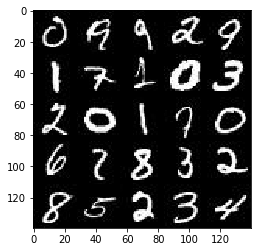

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

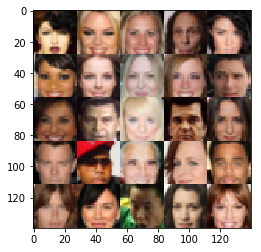

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input')
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        output = tf.layers.conv2d(
            images,
            32,
            5,
            strides=2,
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d(
            output,
            64,
            5,
            strides=2,
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        output = tf.layers.batch_normalization(output, training=True)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d(
            output,
            128,
            5,
            strides=2,
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        output = tf.layers.batch_normalization(output, training=True)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d(
            output,
            256,
            5,
            strides=2,
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        output = tf.layers.batch_normalization(output, training=True)
        output = leaky_relu(output, alpha=alpha)
        
        # Dropout
        output = tf.nn.dropout(output, 0.8)
        
        output = tf.reshape(output, (-1, 4*4*256))
        
        logits = tf.layers.dense(output, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        output = tf.layers.dense(z, 4*4*512)
        
        output = tf.reshape(output, (-1, 4, 4, 512))
        output = tf.layers.batch_normalization(output, training=is_train)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d_transpose(output, 128, 4, strides=1, padding='valid')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d_transpose(output, 64, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.layers.conv2d_transpose(output, 32, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = leaky_relu(output, alpha=alpha)
        
        output = tf.nn.dropout(output, 0.5)
        
        logits = tf.layers.conv2d_transpose(output, out_channel_dim, 3, strides=1, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # Smoothing 
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * (1 - smooth)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_t, z_t, learning_rate_t = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_t, z_t, image_channels, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
    
    step = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                
                random_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Discriminator
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                # Generator
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                # To avoid the fast convergence of D (discriminator) network, G (generator) network is updated twice for each D network update
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({
                        z_t: random_noise,
                        input_t: batch_images
                    })
                    
                    train_loss_g = g_loss.eval({
                        z_t: random_noise
                    })
                    
                    print(
                        "Epoch {}/{}".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    losses.append((train_loss_d, train_loss_g))
                    
                if step % 100 == 0:
                    show_generator_output(sess, 7**2, z_t, image_channels, data_image_mode)
                    
        pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title('Training Losses')
        pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 2.3363 Generator Loss: 0.3412
Epoch 1/2 Discriminator Loss: 1.1347 Generator Loss: 1.1655
Epoch 1/2 Discriminator Loss: 1.2765 Generator Loss: 1.1263
Epoch 1/2 Discriminator Loss: 1.0035 Generator Loss: 0.8065
Epoch 1/2 Discriminator Loss: 1.5232 Generator Loss: 5.0549
Epoch 1/2 Discriminator Loss: 0.8755 Generator Loss: 1.1500
Epoch 1/2 Discriminator Loss: 0.7160 Generator Loss: 2.2772
Epoch 1/2 Discriminator Loss: 0.6483 Generator Loss: 2.1676
Epoch 1/2 Discriminator Loss: 1.6863 Generator Loss: 0.3976
Epoch 1/2 Discriminator Loss: 1.4566 Generator Loss: 0.5349


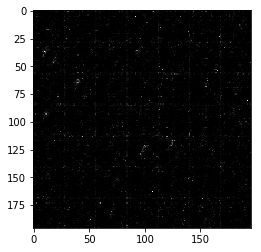

Epoch 1/2 Discriminator Loss: 1.3180 Generator Loss: 0.6424
Epoch 1/2 Discriminator Loss: 1.5739 Generator Loss: 0.5558
Epoch 1/2 Discriminator Loss: 1.5786 Generator Loss: 0.4271
Epoch 1/2 Discriminator Loss: 1.1726 Generator Loss: 1.5532
Epoch 1/2 Discriminator Loss: 1.3050 Generator Loss: 1.3239
Epoch 1/2 Discriminator Loss: 1.0078 Generator Loss: 1.1258
Epoch 1/2 Discriminator Loss: 1.3639 Generator Loss: 0.8357
Epoch 1/2 Discriminator Loss: 1.7344 Generator Loss: 1.4030
Epoch 1/2 Discriminator Loss: 1.5932 Generator Loss: 0.4259
Epoch 1/2 Discriminator Loss: 1.4420 Generator Loss: 0.5768


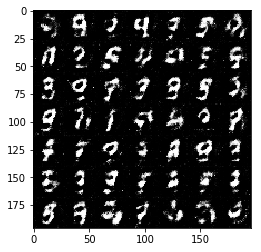

Epoch 1/2 Discriminator Loss: 1.2346 Generator Loss: 0.9746
Epoch 1/2 Discriminator Loss: 1.5157 Generator Loss: 0.8696
Epoch 1/2 Discriminator Loss: 1.5682 Generator Loss: 0.6376
Epoch 1/2 Discriminator Loss: 1.2814 Generator Loss: 1.0286
Epoch 1/2 Discriminator Loss: 1.6748 Generator Loss: 0.3722
Epoch 1/2 Discriminator Loss: 1.6303 Generator Loss: 0.3324
Epoch 1/2 Discriminator Loss: 1.3356 Generator Loss: 0.7125
Epoch 1/2 Discriminator Loss: 1.2993 Generator Loss: 1.1442
Epoch 1/2 Discriminator Loss: 1.4672 Generator Loss: 0.4810
Epoch 1/2 Discriminator Loss: 1.3001 Generator Loss: 1.2284


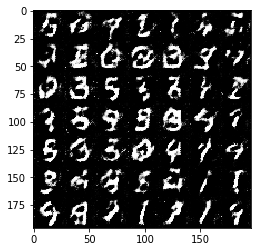

Epoch 1/2 Discriminator Loss: 1.4006 Generator Loss: 0.6970
Epoch 1/2 Discriminator Loss: 1.9242 Generator Loss: 0.2654
Epoch 1/2 Discriminator Loss: 1.3378 Generator Loss: 0.7621
Epoch 1/2 Discriminator Loss: 1.3572 Generator Loss: 0.8524
Epoch 1/2 Discriminator Loss: 1.3062 Generator Loss: 0.7594
Epoch 1/2 Discriminator Loss: 1.5205 Generator Loss: 0.9755
Epoch 1/2 Discriminator Loss: 1.7039 Generator Loss: 0.4068
Epoch 1/2 Discriminator Loss: 1.3384 Generator Loss: 0.5683
Epoch 1/2 Discriminator Loss: 1.4181 Generator Loss: 0.5788
Epoch 1/2 Discriminator Loss: 1.6979 Generator Loss: 0.3130


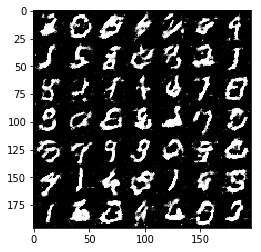

Epoch 1/2 Discriminator Loss: 1.2650 Generator Loss: 0.7711
Epoch 1/2 Discriminator Loss: 1.4934 Generator Loss: 0.6653
Epoch 1/2 Discriminator Loss: 1.2557 Generator Loss: 0.8339
Epoch 1/2 Discriminator Loss: 1.6615 Generator Loss: 0.4495
Epoch 1/2 Discriminator Loss: 1.7804 Generator Loss: 0.4226
Epoch 1/2 Discriminator Loss: 1.6333 Generator Loss: 0.8403
Epoch 1/2 Discriminator Loss: 1.4329 Generator Loss: 0.7060
Epoch 1/2 Discriminator Loss: 1.4144 Generator Loss: 0.5788
Epoch 1/2 Discriminator Loss: 1.4711 Generator Loss: 0.8025
Epoch 1/2 Discriminator Loss: 1.4053 Generator Loss: 0.7604


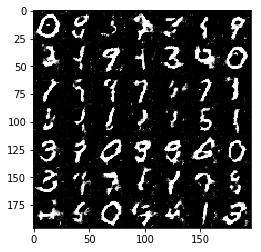

Epoch 1/2 Discriminator Loss: 1.4104 Generator Loss: 0.7565
Epoch 1/2 Discriminator Loss: 1.6310 Generator Loss: 0.3863
Epoch 1/2 Discriminator Loss: 1.2065 Generator Loss: 1.1606
Epoch 1/2 Discriminator Loss: 1.4944 Generator Loss: 1.6322
Epoch 1/2 Discriminator Loss: 1.5682 Generator Loss: 0.6452
Epoch 1/2 Discriminator Loss: 1.3012 Generator Loss: 0.9019
Epoch 1/2 Discriminator Loss: 1.1980 Generator Loss: 0.8518
Epoch 1/2 Discriminator Loss: 1.4497 Generator Loss: 0.5563
Epoch 1/2 Discriminator Loss: 1.5640 Generator Loss: 0.3739
Epoch 1/2 Discriminator Loss: 1.3502 Generator Loss: 0.6345


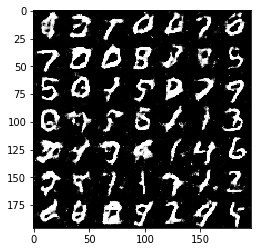

Epoch 1/2 Discriminator Loss: 1.2728 Generator Loss: 0.8782
Epoch 1/2 Discriminator Loss: 1.5570 Generator Loss: 0.4650
Epoch 1/2 Discriminator Loss: 1.4764 Generator Loss: 1.1515
Epoch 1/2 Discriminator Loss: 1.5021 Generator Loss: 0.6662
Epoch 1/2 Discriminator Loss: 1.6654 Generator Loss: 0.4301
Epoch 1/2 Discriminator Loss: 1.3700 Generator Loss: 0.6008
Epoch 1/2 Discriminator Loss: 1.2146 Generator Loss: 0.8441
Epoch 1/2 Discriminator Loss: 1.6976 Generator Loss: 0.3428
Epoch 1/2 Discriminator Loss: 1.5675 Generator Loss: 0.4269
Epoch 1/2 Discriminator Loss: 1.2502 Generator Loss: 0.7064


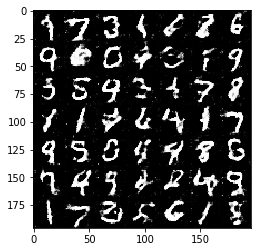

Epoch 1/2 Discriminator Loss: 1.3964 Generator Loss: 0.9956
Epoch 1/2 Discriminator Loss: 1.3284 Generator Loss: 0.9306
Epoch 1/2 Discriminator Loss: 1.4747 Generator Loss: 0.6109
Epoch 1/2 Discriminator Loss: 1.7807 Generator Loss: 0.3830
Epoch 1/2 Discriminator Loss: 1.4061 Generator Loss: 0.5934
Epoch 1/2 Discriminator Loss: 1.8600 Generator Loss: 0.3414
Epoch 1/2 Discriminator Loss: 1.3549 Generator Loss: 0.4943
Epoch 1/2 Discriminator Loss: 2.0117 Generator Loss: 0.3333
Epoch 1/2 Discriminator Loss: 1.3773 Generator Loss: 0.5943
Epoch 1/2 Discriminator Loss: 1.3430 Generator Loss: 0.6299


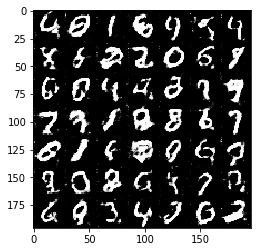

Epoch 1/2 Discriminator Loss: 1.7142 Generator Loss: 0.3816
Epoch 1/2 Discriminator Loss: 1.3906 Generator Loss: 0.7738
Epoch 1/2 Discriminator Loss: 1.1578 Generator Loss: 0.8922
Epoch 1/2 Discriminator Loss: 1.8217 Generator Loss: 0.2725
Epoch 1/2 Discriminator Loss: 1.6632 Generator Loss: 0.5192
Epoch 1/2 Discriminator Loss: 1.4152 Generator Loss: 0.5771
Epoch 1/2 Discriminator Loss: 1.3685 Generator Loss: 0.9022
Epoch 1/2 Discriminator Loss: 1.2316 Generator Loss: 1.0928
Epoch 1/2 Discriminator Loss: 1.4338 Generator Loss: 0.7990
Epoch 1/2 Discriminator Loss: 2.2171 Generator Loss: 0.1853


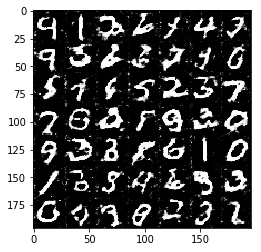

Epoch 1/2 Discriminator Loss: 1.7912 Generator Loss: 0.3053
Epoch 1/2 Discriminator Loss: 1.0294 Generator Loss: 1.4545
Epoch 1/2 Discriminator Loss: 1.3887 Generator Loss: 0.5357
Epoch 2/2 Discriminator Loss: 1.2430 Generator Loss: 1.1574
Epoch 2/2 Discriminator Loss: 1.5005 Generator Loss: 1.4403
Epoch 2/2 Discriminator Loss: 1.5497 Generator Loss: 1.0666
Epoch 2/2 Discriminator Loss: 1.2901 Generator Loss: 1.1395
Epoch 2/2 Discriminator Loss: 1.5481 Generator Loss: 0.3337
Epoch 2/2 Discriminator Loss: 1.7209 Generator Loss: 0.3680
Epoch 2/2 Discriminator Loss: 1.2179 Generator Loss: 0.7479


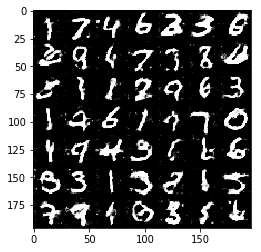

Epoch 2/2 Discriminator Loss: 1.6055 Generator Loss: 0.5737
Epoch 2/2 Discriminator Loss: 1.1769 Generator Loss: 0.5354
Epoch 2/2 Discriminator Loss: 1.2525 Generator Loss: 1.2042
Epoch 2/2 Discriminator Loss: 1.3564 Generator Loss: 0.5675
Epoch 2/2 Discriminator Loss: 1.3898 Generator Loss: 0.6358
Epoch 2/2 Discriminator Loss: 1.3680 Generator Loss: 0.7803
Epoch 2/2 Discriminator Loss: 1.2750 Generator Loss: 0.5943
Epoch 2/2 Discriminator Loss: 1.4216 Generator Loss: 0.4983
Epoch 2/2 Discriminator Loss: 1.5743 Generator Loss: 0.6788
Epoch 2/2 Discriminator Loss: 1.6171 Generator Loss: 0.4250


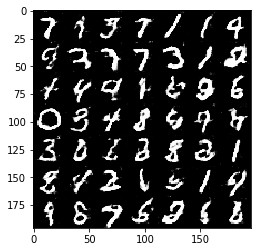

Epoch 2/2 Discriminator Loss: 1.4960 Generator Loss: 0.6739
Epoch 2/2 Discriminator Loss: 1.2006 Generator Loss: 0.8823
Epoch 2/2 Discriminator Loss: 1.5426 Generator Loss: 0.7805
Epoch 2/2 Discriminator Loss: 1.3252 Generator Loss: 0.8789
Epoch 2/2 Discriminator Loss: 1.6493 Generator Loss: 0.3512
Epoch 2/2 Discriminator Loss: 1.7729 Generator Loss: 0.2666
Epoch 2/2 Discriminator Loss: 1.3927 Generator Loss: 0.6809
Epoch 2/2 Discriminator Loss: 1.2131 Generator Loss: 0.5692
Epoch 2/2 Discriminator Loss: 2.2703 Generator Loss: 0.1671
Epoch 2/2 Discriminator Loss: 1.3725 Generator Loss: 0.5298


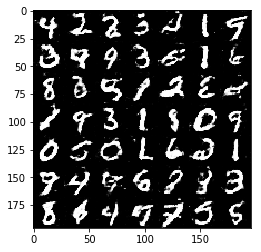

Epoch 2/2 Discriminator Loss: 1.5613 Generator Loss: 0.6578
Epoch 2/2 Discriminator Loss: 1.4472 Generator Loss: 0.5432
Epoch 2/2 Discriminator Loss: 1.3441 Generator Loss: 0.7477
Epoch 2/2 Discriminator Loss: 1.2764 Generator Loss: 0.6903
Epoch 2/2 Discriminator Loss: 1.7288 Generator Loss: 2.0796
Epoch 2/2 Discriminator Loss: 1.5179 Generator Loss: 0.4752
Epoch 2/2 Discriminator Loss: 1.4657 Generator Loss: 0.7410
Epoch 2/2 Discriminator Loss: 1.2876 Generator Loss: 0.9780
Epoch 2/2 Discriminator Loss: 1.1520 Generator Loss: 0.7857
Epoch 2/2 Discriminator Loss: 1.2659 Generator Loss: 0.7091


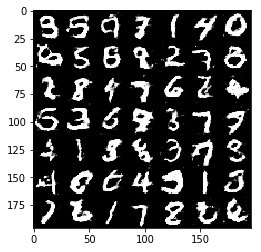

Epoch 2/2 Discriminator Loss: 1.3292 Generator Loss: 0.9498
Epoch 2/2 Discriminator Loss: 1.9551 Generator Loss: 0.3312
Epoch 2/2 Discriminator Loss: 1.3030 Generator Loss: 1.6230
Epoch 2/2 Discriminator Loss: 2.0253 Generator Loss: 0.3158
Epoch 2/2 Discriminator Loss: 1.2855 Generator Loss: 0.8689
Epoch 2/2 Discriminator Loss: 1.3599 Generator Loss: 1.1009
Epoch 2/2 Discriminator Loss: 1.5148 Generator Loss: 0.5799
Epoch 2/2 Discriminator Loss: 1.7668 Generator Loss: 0.4331
Epoch 2/2 Discriminator Loss: 1.3722 Generator Loss: 1.3534
Epoch 2/2 Discriminator Loss: 1.4283 Generator Loss: 0.5357


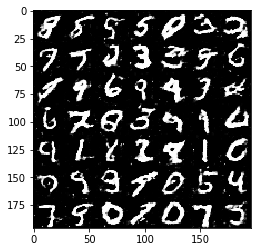

Epoch 2/2 Discriminator Loss: 1.8829 Generator Loss: 0.3184
Epoch 2/2 Discriminator Loss: 1.4016 Generator Loss: 0.4838
Epoch 2/2 Discriminator Loss: 2.3170 Generator Loss: 2.1170
Epoch 2/2 Discriminator Loss: 1.5066 Generator Loss: 0.4310
Epoch 2/2 Discriminator Loss: 1.3354 Generator Loss: 0.4280
Epoch 2/2 Discriminator Loss: 1.4120 Generator Loss: 0.8661
Epoch 2/2 Discriminator Loss: 1.4711 Generator Loss: 0.5119
Epoch 2/2 Discriminator Loss: 1.2688 Generator Loss: 0.9637
Epoch 2/2 Discriminator Loss: 1.6019 Generator Loss: 1.1218
Epoch 2/2 Discriminator Loss: 1.1889 Generator Loss: 0.5673


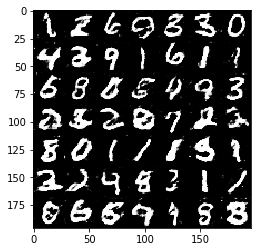

Epoch 2/2 Discriminator Loss: 1.8542 Generator Loss: 0.3881
Epoch 2/2 Discriminator Loss: 1.2103 Generator Loss: 0.8903
Epoch 2/2 Discriminator Loss: 1.6402 Generator Loss: 0.3949
Epoch 2/2 Discriminator Loss: 1.5621 Generator Loss: 0.4872
Epoch 2/2 Discriminator Loss: 1.2838 Generator Loss: 0.4453
Epoch 2/2 Discriminator Loss: 1.5342 Generator Loss: 0.7929
Epoch 2/2 Discriminator Loss: 1.4418 Generator Loss: 0.9701
Epoch 2/2 Discriminator Loss: 1.5277 Generator Loss: 0.5382
Epoch 2/2 Discriminator Loss: 1.6074 Generator Loss: 0.3711
Epoch 2/2 Discriminator Loss: 1.4284 Generator Loss: 0.5672


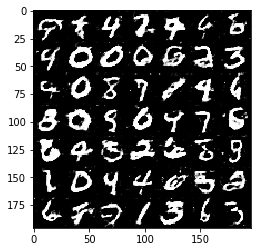

Epoch 2/2 Discriminator Loss: 1.3327 Generator Loss: 0.7977
Epoch 2/2 Discriminator Loss: 1.6543 Generator Loss: 0.3891
Epoch 2/2 Discriminator Loss: 1.4309 Generator Loss: 0.5423
Epoch 2/2 Discriminator Loss: 1.4707 Generator Loss: 1.5215
Epoch 2/2 Discriminator Loss: 1.3401 Generator Loss: 0.8045
Epoch 2/2 Discriminator Loss: 1.5565 Generator Loss: 0.3291
Epoch 2/2 Discriminator Loss: 1.2394 Generator Loss: 0.6330
Epoch 2/2 Discriminator Loss: 1.8550 Generator Loss: 0.3300
Epoch 2/2 Discriminator Loss: 1.3741 Generator Loss: 0.5897
Epoch 2/2 Discriminator Loss: 1.3458 Generator Loss: 0.9514


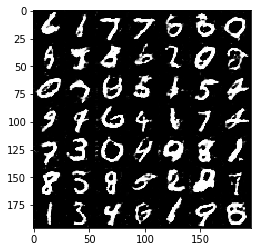

Epoch 2/2 Discriminator Loss: 1.5959 Generator Loss: 0.4732
Epoch 2/2 Discriminator Loss: 1.5953 Generator Loss: 0.4701
Epoch 2/2 Discriminator Loss: 1.9046 Generator Loss: 0.2948
Epoch 2/2 Discriminator Loss: 1.4209 Generator Loss: 0.5654
Epoch 2/2 Discriminator Loss: 1.1993 Generator Loss: 0.5504
Epoch 2/2 Discriminator Loss: 1.5559 Generator Loss: 0.3909
Epoch 2/2 Discriminator Loss: 1.2947 Generator Loss: 0.5743
Epoch 2/2 Discriminator Loss: 1.3000 Generator Loss: 0.6279
Epoch 2/2 Discriminator Loss: 1.2207 Generator Loss: 0.5401
Epoch 2/2 Discriminator Loss: 1.4362 Generator Loss: 0.4753


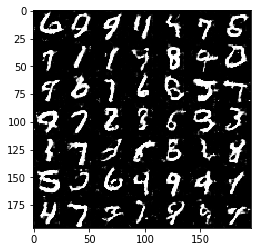

Epoch 2/2 Discriminator Loss: 1.3816 Generator Loss: 0.5372
Epoch 2/2 Discriminator Loss: 1.8033 Generator Loss: 0.3508
Epoch 2/2 Discriminator Loss: 1.5180 Generator Loss: 0.4747
Epoch 2/2 Discriminator Loss: 1.6869 Generator Loss: 0.3533
Epoch 2/2 Discriminator Loss: 1.4381 Generator Loss: 0.8666
Epoch 2/2 Discriminator Loss: 1.1022 Generator Loss: 0.8491
Epoch 2/2 Discriminator Loss: 1.5732 Generator Loss: 0.4961


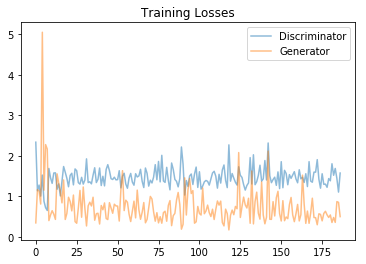

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 0.6420 Generator Loss: 2.9807
Epoch 1/1 Discriminator Loss: 0.7526 Generator Loss: 1.9986
Epoch 1/1 Discriminator Loss: 0.5496 Generator Loss: 3.8542
Epoch 1/1 Discriminator Loss: 0.3829 Generator Loss: 5.0814
Epoch 1/1 Discriminator Loss: 0.4374 Generator Loss: 3.7044
Epoch 1/1 Discriminator Loss: 0.4876 Generator Loss: 2.1790
Epoch 1/1 Discriminator Loss: 0.4846 Generator Loss: 3.1889
Epoch 1/1 Discriminator Loss: 0.4288 Generator Loss: 2.9208
Epoch 1/1 Discriminator Loss: 0.5840 Generator Loss: 1.8603
Epoch 1/1 Discriminator Loss: 0.5090 Generator Loss: 2.2897


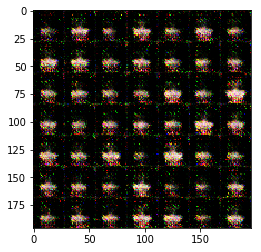

Epoch 1/1 Discriminator Loss: 0.8442 Generator Loss: 1.5924
Epoch 1/1 Discriminator Loss: 1.6079 Generator Loss: 0.5505
Epoch 1/1 Discriminator Loss: 1.0651 Generator Loss: 0.7544
Epoch 1/1 Discriminator Loss: 1.2766 Generator Loss: 4.3751
Epoch 1/1 Discriminator Loss: 0.6849 Generator Loss: 1.5460
Epoch 1/1 Discriminator Loss: 1.6728 Generator Loss: 0.4240
Epoch 1/1 Discriminator Loss: 0.6769 Generator Loss: 1.8556
Epoch 1/1 Discriminator Loss: 2.0844 Generator Loss: 0.2861
Epoch 1/1 Discriminator Loss: 1.0638 Generator Loss: 2.7986
Epoch 1/1 Discriminator Loss: 0.8412 Generator Loss: 2.3943


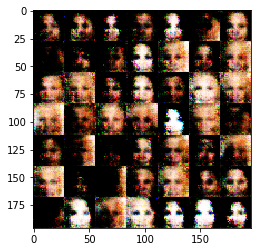

Epoch 1/1 Discriminator Loss: 1.3357 Generator Loss: 0.6558
Epoch 1/1 Discriminator Loss: 0.7950 Generator Loss: 1.5056
Epoch 1/1 Discriminator Loss: 1.4787 Generator Loss: 0.5226
Epoch 1/1 Discriminator Loss: 1.5888 Generator Loss: 2.6051
Epoch 1/1 Discriminator Loss: 1.3124 Generator Loss: 0.8488
Epoch 1/1 Discriminator Loss: 1.7860 Generator Loss: 0.3390
Epoch 1/1 Discriminator Loss: 1.0934 Generator Loss: 1.2992
Epoch 1/1 Discriminator Loss: 1.0113 Generator Loss: 0.9314
Epoch 1/1 Discriminator Loss: 1.1975 Generator Loss: 0.8450
Epoch 1/1 Discriminator Loss: 1.1733 Generator Loss: 0.7834


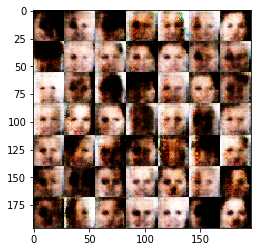

Epoch 1/1 Discriminator Loss: 1.5568 Generator Loss: 0.4507
Epoch 1/1 Discriminator Loss: 1.5258 Generator Loss: 2.6642
Epoch 1/1 Discriminator Loss: 0.8936 Generator Loss: 1.2444
Epoch 1/1 Discriminator Loss: 1.1342 Generator Loss: 0.4741
Epoch 1/1 Discriminator Loss: 1.2396 Generator Loss: 0.8090
Epoch 1/1 Discriminator Loss: 1.1617 Generator Loss: 1.6793
Epoch 1/1 Discriminator Loss: 1.5923 Generator Loss: 0.4779
Epoch 1/1 Discriminator Loss: 0.7969 Generator Loss: 1.7001
Epoch 1/1 Discriminator Loss: 1.0271 Generator Loss: 1.5118
Epoch 1/1 Discriminator Loss: 0.9603 Generator Loss: 1.6565


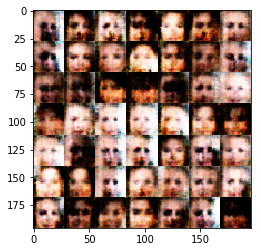

Epoch 1/1 Discriminator Loss: 1.0863 Generator Loss: 0.8076
Epoch 1/1 Discriminator Loss: 1.3588 Generator Loss: 0.4836
Epoch 1/1 Discriminator Loss: 1.2423 Generator Loss: 1.2188
Epoch 1/1 Discriminator Loss: 1.1644 Generator Loss: 0.7543
Epoch 1/1 Discriminator Loss: 1.7206 Generator Loss: 0.3504
Epoch 1/1 Discriminator Loss: 1.2156 Generator Loss: 0.8171
Epoch 1/1 Discriminator Loss: 1.4165 Generator Loss: 0.7547
Epoch 1/1 Discriminator Loss: 1.3888 Generator Loss: 0.7447
Epoch 1/1 Discriminator Loss: 1.4255 Generator Loss: 0.7010
Epoch 1/1 Discriminator Loss: 1.2657 Generator Loss: 1.3016


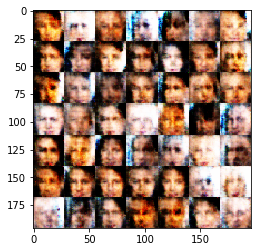

Epoch 1/1 Discriminator Loss: 1.1424 Generator Loss: 1.2528
Epoch 1/1 Discriminator Loss: 1.3553 Generator Loss: 0.6209
Epoch 1/1 Discriminator Loss: 1.2543 Generator Loss: 1.1415
Epoch 1/1 Discriminator Loss: 1.4174 Generator Loss: 0.8673
Epoch 1/1 Discriminator Loss: 1.8120 Generator Loss: 0.3568
Epoch 1/1 Discriminator Loss: 1.3682 Generator Loss: 1.2277
Epoch 1/1 Discriminator Loss: 1.2320 Generator Loss: 0.7396
Epoch 1/1 Discriminator Loss: 1.7007 Generator Loss: 0.3810
Epoch 1/1 Discriminator Loss: 1.4911 Generator Loss: 0.6899
Epoch 1/1 Discriminator Loss: 1.4007 Generator Loss: 0.4257


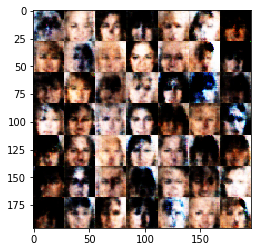

Epoch 1/1 Discriminator Loss: 1.2728 Generator Loss: 1.9892
Epoch 1/1 Discriminator Loss: 1.2082 Generator Loss: 0.9250
Epoch 1/1 Discriminator Loss: 1.2921 Generator Loss: 1.0371
Epoch 1/1 Discriminator Loss: 1.3491 Generator Loss: 0.6767
Epoch 1/1 Discriminator Loss: 1.6670 Generator Loss: 0.9973
Epoch 1/1 Discriminator Loss: 1.2959 Generator Loss: 0.8673
Epoch 1/1 Discriminator Loss: 1.1872 Generator Loss: 1.1646
Epoch 1/1 Discriminator Loss: 1.4127 Generator Loss: 0.4660
Epoch 1/1 Discriminator Loss: 1.4018 Generator Loss: 0.6197
Epoch 1/1 Discriminator Loss: 1.1113 Generator Loss: 0.9889


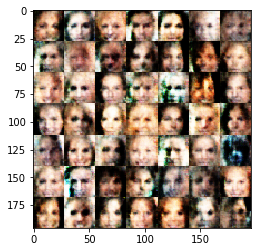

Epoch 1/1 Discriminator Loss: 1.3553 Generator Loss: 0.9058
Epoch 1/1 Discriminator Loss: 1.3395 Generator Loss: 1.2777
Epoch 1/1 Discriminator Loss: 1.4041 Generator Loss: 1.0817
Epoch 1/1 Discriminator Loss: 1.0184 Generator Loss: 1.1902
Epoch 1/1 Discriminator Loss: 1.3309 Generator Loss: 0.7331
Epoch 1/1 Discriminator Loss: 1.5870 Generator Loss: 0.5364
Epoch 1/1 Discriminator Loss: 1.4263 Generator Loss: 0.9419
Epoch 1/1 Discriminator Loss: 1.5292 Generator Loss: 0.4712
Epoch 1/1 Discriminator Loss: 1.3043 Generator Loss: 0.9016
Epoch 1/1 Discriminator Loss: 1.2637 Generator Loss: 0.5932


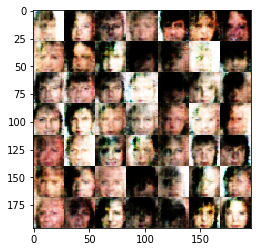

Epoch 1/1 Discriminator Loss: 1.2413 Generator Loss: 0.8104
Epoch 1/1 Discriminator Loss: 1.1389 Generator Loss: 1.3156
Epoch 1/1 Discriminator Loss: 1.5780 Generator Loss: 0.6127
Epoch 1/1 Discriminator Loss: 1.4453 Generator Loss: 0.6987
Epoch 1/1 Discriminator Loss: 1.4758 Generator Loss: 0.6786
Epoch 1/1 Discriminator Loss: 1.4089 Generator Loss: 0.6832
Epoch 1/1 Discriminator Loss: 1.4332 Generator Loss: 0.6074
Epoch 1/1 Discriminator Loss: 1.2176 Generator Loss: 1.0611
Epoch 1/1 Discriminator Loss: 1.4131 Generator Loss: 0.6648
Epoch 1/1 Discriminator Loss: 1.3701 Generator Loss: 0.9097


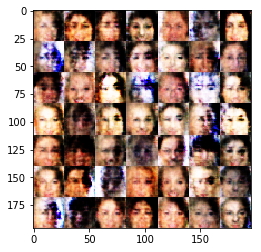

Epoch 1/1 Discriminator Loss: 1.3773 Generator Loss: 0.6362
Epoch 1/1 Discriminator Loss: 1.1507 Generator Loss: 0.6545
Epoch 1/1 Discriminator Loss: 1.4808 Generator Loss: 0.7083
Epoch 1/1 Discriminator Loss: 1.4725 Generator Loss: 0.5697
Epoch 1/1 Discriminator Loss: 1.6814 Generator Loss: 0.5575
Epoch 1/1 Discriminator Loss: 1.5829 Generator Loss: 0.4876
Epoch 1/1 Discriminator Loss: 1.3660 Generator Loss: 0.8069
Epoch 1/1 Discriminator Loss: 1.0729 Generator Loss: 0.6627
Epoch 1/1 Discriminator Loss: 1.4305 Generator Loss: 0.6064
Epoch 1/1 Discriminator Loss: 1.3159 Generator Loss: 0.6372


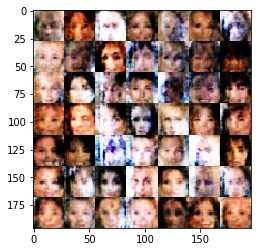

Epoch 1/1 Discriminator Loss: 1.2843 Generator Loss: 0.9231
Epoch 1/1 Discriminator Loss: 1.4208 Generator Loss: 0.6599
Epoch 1/1 Discriminator Loss: 1.6078 Generator Loss: 0.5906
Epoch 1/1 Discriminator Loss: 1.2928 Generator Loss: 0.6084
Epoch 1/1 Discriminator Loss: 1.5201 Generator Loss: 0.7470
Epoch 1/1 Discriminator Loss: 1.3001 Generator Loss: 0.6131
Epoch 1/1 Discriminator Loss: 1.3122 Generator Loss: 0.7115
Epoch 1/1 Discriminator Loss: 1.3273 Generator Loss: 0.6750
Epoch 1/1 Discriminator Loss: 1.1887 Generator Loss: 0.7542
Epoch 1/1 Discriminator Loss: 1.2435 Generator Loss: 0.8161


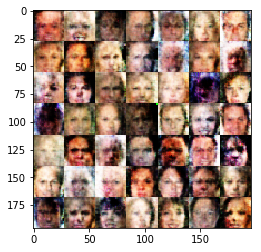

Epoch 1/1 Discriminator Loss: 1.3953 Generator Loss: 0.5605
Epoch 1/1 Discriminator Loss: 1.5383 Generator Loss: 0.6654
Epoch 1/1 Discriminator Loss: 1.3223 Generator Loss: 0.6817
Epoch 1/1 Discriminator Loss: 1.2772 Generator Loss: 0.6878
Epoch 1/1 Discriminator Loss: 1.5296 Generator Loss: 0.5011
Epoch 1/1 Discriminator Loss: 1.3998 Generator Loss: 0.7851
Epoch 1/1 Discriminator Loss: 1.2743 Generator Loss: 0.7211
Epoch 1/1 Discriminator Loss: 1.4049 Generator Loss: 0.7980
Epoch 1/1 Discriminator Loss: 1.3540 Generator Loss: 0.5825
Epoch 1/1 Discriminator Loss: 1.4252 Generator Loss: 0.6595


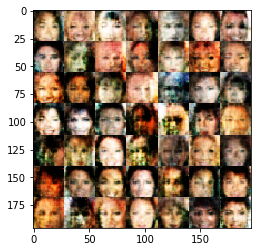

Epoch 1/1 Discriminator Loss: 1.4756 Generator Loss: 0.6909
Epoch 1/1 Discriminator Loss: 1.4050 Generator Loss: 0.7770
Epoch 1/1 Discriminator Loss: 1.5078 Generator Loss: 0.5504
Epoch 1/1 Discriminator Loss: 1.5510 Generator Loss: 0.6699
Epoch 1/1 Discriminator Loss: 1.4378 Generator Loss: 0.6659
Epoch 1/1 Discriminator Loss: 1.4882 Generator Loss: 0.7639
Epoch 1/1 Discriminator Loss: 1.6235 Generator Loss: 0.5857
Epoch 1/1 Discriminator Loss: 1.5838 Generator Loss: 0.4772
Epoch 1/1 Discriminator Loss: 1.6461 Generator Loss: 0.4922
Epoch 1/1 Discriminator Loss: 1.3103 Generator Loss: 0.9467


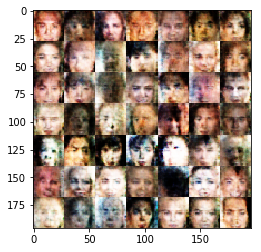

Epoch 1/1 Discriminator Loss: 1.3908 Generator Loss: 0.7953
Epoch 1/1 Discriminator Loss: 1.4584 Generator Loss: 0.5735
Epoch 1/1 Discriminator Loss: 1.7850 Generator Loss: 0.4640
Epoch 1/1 Discriminator Loss: 1.4117 Generator Loss: 0.6238
Epoch 1/1 Discriminator Loss: 1.4911 Generator Loss: 0.5631
Epoch 1/1 Discriminator Loss: 1.4092 Generator Loss: 0.5976
Epoch 1/1 Discriminator Loss: 1.4650 Generator Loss: 0.6679
Epoch 1/1 Discriminator Loss: 1.4391 Generator Loss: 0.7680
Epoch 1/1 Discriminator Loss: 1.4630 Generator Loss: 0.5790
Epoch 1/1 Discriminator Loss: 1.3609 Generator Loss: 0.6609


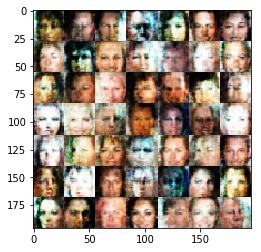

Epoch 1/1 Discriminator Loss: 1.3659 Generator Loss: 0.7334
Epoch 1/1 Discriminator Loss: 1.2742 Generator Loss: 0.7916
Epoch 1/1 Discriminator Loss: 1.4464 Generator Loss: 0.7823
Epoch 1/1 Discriminator Loss: 1.2130 Generator Loss: 0.8213
Epoch 1/1 Discriminator Loss: 1.4720 Generator Loss: 0.7613
Epoch 1/1 Discriminator Loss: 1.3225 Generator Loss: 0.8822
Epoch 1/1 Discriminator Loss: 1.4199 Generator Loss: 0.6595
Epoch 1/1 Discriminator Loss: 1.4398 Generator Loss: 0.8238
Epoch 1/1 Discriminator Loss: 1.3801 Generator Loss: 0.6683
Epoch 1/1 Discriminator Loss: 1.6429 Generator Loss: 0.6039


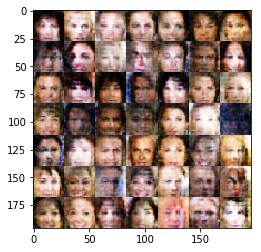

Epoch 1/1 Discriminator Loss: 1.5940 Generator Loss: 0.6376
Epoch 1/1 Discriminator Loss: 1.4677 Generator Loss: 0.7191
Epoch 1/1 Discriminator Loss: 1.4747 Generator Loss: 0.5896
Epoch 1/1 Discriminator Loss: 1.4087 Generator Loss: 0.7131
Epoch 1/1 Discriminator Loss: 1.5689 Generator Loss: 0.6441
Epoch 1/1 Discriminator Loss: 1.2497 Generator Loss: 0.6468
Epoch 1/1 Discriminator Loss: 1.4924 Generator Loss: 0.8799
Epoch 1/1 Discriminator Loss: 1.6518 Generator Loss: 0.5376
Epoch 1/1 Discriminator Loss: 1.4881 Generator Loss: 0.6628
Epoch 1/1 Discriminator Loss: 1.3254 Generator Loss: 0.8944


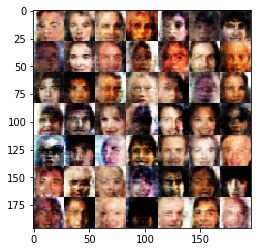

Epoch 1/1 Discriminator Loss: 1.3606 Generator Loss: 0.9023
Epoch 1/1 Discriminator Loss: 1.3804 Generator Loss: 0.7150
Epoch 1/1 Discriminator Loss: 1.4919 Generator Loss: 0.6819
Epoch 1/1 Discriminator Loss: 1.5408 Generator Loss: 0.6815
Epoch 1/1 Discriminator Loss: 1.5087 Generator Loss: 0.7931
Epoch 1/1 Discriminator Loss: 1.5237 Generator Loss: 0.6263
Epoch 1/1 Discriminator Loss: 1.2523 Generator Loss: 0.6553
Epoch 1/1 Discriminator Loss: 1.4504 Generator Loss: 0.8593
Epoch 1/1 Discriminator Loss: 1.4487 Generator Loss: 0.7304
Epoch 1/1 Discriminator Loss: 1.5802 Generator Loss: 0.6521


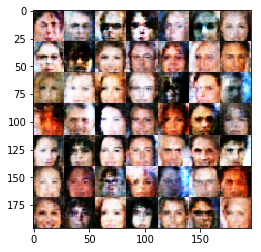

Epoch 1/1 Discriminator Loss: 1.3970 Generator Loss: 0.7403
Epoch 1/1 Discriminator Loss: 1.2958 Generator Loss: 0.6771
Epoch 1/1 Discriminator Loss: 1.4855 Generator Loss: 0.7333
Epoch 1/1 Discriminator Loss: 1.5202 Generator Loss: 0.6895
Epoch 1/1 Discriminator Loss: 1.5255 Generator Loss: 0.6536
Epoch 1/1 Discriminator Loss: 1.3969 Generator Loss: 0.6239
Epoch 1/1 Discriminator Loss: 1.4082 Generator Loss: 0.6485
Epoch 1/1 Discriminator Loss: 1.3893 Generator Loss: 0.7393
Epoch 1/1 Discriminator Loss: 1.2522 Generator Loss: 0.8106
Epoch 1/1 Discriminator Loss: 1.4175 Generator Loss: 0.7171


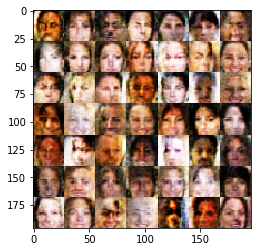

Epoch 1/1 Discriminator Loss: 1.3776 Generator Loss: 0.6884
Epoch 1/1 Discriminator Loss: 1.3131 Generator Loss: 0.7744
Epoch 1/1 Discriminator Loss: 1.4026 Generator Loss: 0.7225
Epoch 1/1 Discriminator Loss: 1.5262 Generator Loss: 0.5836
Epoch 1/1 Discriminator Loss: 1.5205 Generator Loss: 0.6068
Epoch 1/1 Discriminator Loss: 1.5037 Generator Loss: 0.6659
Epoch 1/1 Discriminator Loss: 1.6601 Generator Loss: 0.5878
Epoch 1/1 Discriminator Loss: 1.4348 Generator Loss: 0.7028
Epoch 1/1 Discriminator Loss: 1.4536 Generator Loss: 0.6412
Epoch 1/1 Discriminator Loss: 1.4366 Generator Loss: 0.7469


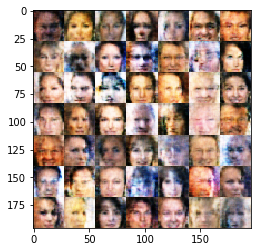

Epoch 1/1 Discriminator Loss: 1.4728 Generator Loss: 0.7366
Epoch 1/1 Discriminator Loss: 1.5102 Generator Loss: 0.7287
Epoch 1/1 Discriminator Loss: 1.4658 Generator Loss: 0.5470
Epoch 1/1 Discriminator Loss: 1.4729 Generator Loss: 0.6095
Epoch 1/1 Discriminator Loss: 1.4477 Generator Loss: 0.7344
Epoch 1/1 Discriminator Loss: 1.4057 Generator Loss: 0.7167
Epoch 1/1 Discriminator Loss: 1.5334 Generator Loss: 0.6409
Epoch 1/1 Discriminator Loss: 1.3668 Generator Loss: 0.6011
Epoch 1/1 Discriminator Loss: 1.4105 Generator Loss: 0.8502
Epoch 1/1 Discriminator Loss: 1.2293 Generator Loss: 0.7848


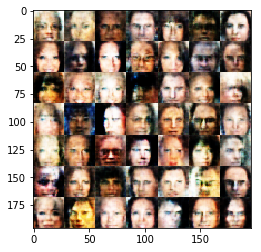

Epoch 1/1 Discriminator Loss: 1.4388 Generator Loss: 0.6475
Epoch 1/1 Discriminator Loss: 1.2099 Generator Loss: 0.7179
Epoch 1/1 Discriminator Loss: 1.5535 Generator Loss: 0.5321
Epoch 1/1 Discriminator Loss: 1.3772 Generator Loss: 0.7301
Epoch 1/1 Discriminator Loss: 1.3766 Generator Loss: 0.6428
Epoch 1/1 Discriminator Loss: 1.4407 Generator Loss: 0.6630
Epoch 1/1 Discriminator Loss: 1.3855 Generator Loss: 0.6843
Epoch 1/1 Discriminator Loss: 1.3473 Generator Loss: 0.5721
Epoch 1/1 Discriminator Loss: 1.3404 Generator Loss: 0.8497
Epoch 1/1 Discriminator Loss: 1.6836 Generator Loss: 0.4815


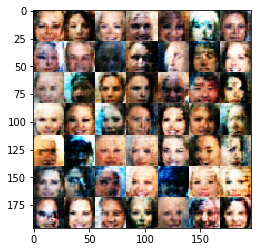

Epoch 1/1 Discriminator Loss: 1.5550 Generator Loss: 0.5647
Epoch 1/1 Discriminator Loss: 1.4837 Generator Loss: 0.5791
Epoch 1/1 Discriminator Loss: 1.2935 Generator Loss: 0.7067
Epoch 1/1 Discriminator Loss: 1.3837 Generator Loss: 0.6188
Epoch 1/1 Discriminator Loss: 1.4331 Generator Loss: 0.7462
Epoch 1/1 Discriminator Loss: 1.3539 Generator Loss: 0.7402
Epoch 1/1 Discriminator Loss: 1.4639 Generator Loss: 0.7244
Epoch 1/1 Discriminator Loss: 1.3752 Generator Loss: 0.6456
Epoch 1/1 Discriminator Loss: 1.6313 Generator Loss: 0.6497
Epoch 1/1 Discriminator Loss: 1.3499 Generator Loss: 0.7751


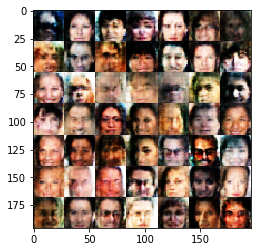

Epoch 1/1 Discriminator Loss: 1.4282 Generator Loss: 0.5567
Epoch 1/1 Discriminator Loss: 1.4895 Generator Loss: 0.7077
Epoch 1/1 Discriminator Loss: 1.5648 Generator Loss: 0.5447
Epoch 1/1 Discriminator Loss: 1.5181 Generator Loss: 0.6591
Epoch 1/1 Discriminator Loss: 1.3908 Generator Loss: 0.6850
Epoch 1/1 Discriminator Loss: 1.9769 Generator Loss: 0.4343
Epoch 1/1 Discriminator Loss: 1.5206 Generator Loss: 0.6423
Epoch 1/1 Discriminator Loss: 1.5425 Generator Loss: 0.6279
Epoch 1/1 Discriminator Loss: 1.4054 Generator Loss: 0.7262
Epoch 1/1 Discriminator Loss: 1.5733 Generator Loss: 0.5796


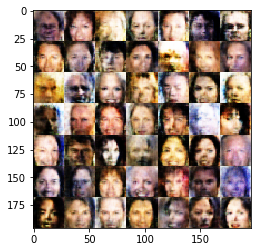

Epoch 1/1 Discriminator Loss: 1.4514 Generator Loss: 0.5513
Epoch 1/1 Discriminator Loss: 1.6499 Generator Loss: 0.6375
Epoch 1/1 Discriminator Loss: 1.4545 Generator Loss: 0.5835
Epoch 1/1 Discriminator Loss: 1.2862 Generator Loss: 0.8046
Epoch 1/1 Discriminator Loss: 1.4681 Generator Loss: 0.5776
Epoch 1/1 Discriminator Loss: 1.5945 Generator Loss: 0.4834
Epoch 1/1 Discriminator Loss: 1.3385 Generator Loss: 0.7763
Epoch 1/1 Discriminator Loss: 1.4435 Generator Loss: 0.5775
Epoch 1/1 Discriminator Loss: 1.4801 Generator Loss: 0.6997
Epoch 1/1 Discriminator Loss: 1.6089 Generator Loss: 0.6204


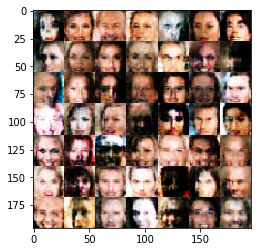

Epoch 1/1 Discriminator Loss: 1.3814 Generator Loss: 0.7387
Epoch 1/1 Discriminator Loss: 1.3754 Generator Loss: 0.7063
Epoch 1/1 Discriminator Loss: 1.3654 Generator Loss: 0.6312
Epoch 1/1 Discriminator Loss: 1.4592 Generator Loss: 0.6745
Epoch 1/1 Discriminator Loss: 1.2863 Generator Loss: 0.7038
Epoch 1/1 Discriminator Loss: 1.5277 Generator Loss: 0.5908
Epoch 1/1 Discriminator Loss: 1.4046 Generator Loss: 0.7230
Epoch 1/1 Discriminator Loss: 1.4995 Generator Loss: 0.8135
Epoch 1/1 Discriminator Loss: 1.4116 Generator Loss: 0.6191
Epoch 1/1 Discriminator Loss: 1.4944 Generator Loss: 0.6678


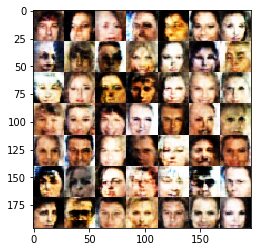

Epoch 1/1 Discriminator Loss: 1.2367 Generator Loss: 0.7359
Epoch 1/1 Discriminator Loss: 1.4817 Generator Loss: 0.6489
Epoch 1/1 Discriminator Loss: 1.4433 Generator Loss: 0.9032
Epoch 1/1 Discriminator Loss: 1.4394 Generator Loss: 0.4953
Epoch 1/1 Discriminator Loss: 1.3402 Generator Loss: 0.8694
Epoch 1/1 Discriminator Loss: 1.3862 Generator Loss: 0.7773
Epoch 1/1 Discriminator Loss: 1.4197 Generator Loss: 0.7038
Epoch 1/1 Discriminator Loss: 1.4485 Generator Loss: 0.6134
Epoch 1/1 Discriminator Loss: 1.3948 Generator Loss: 0.5409
Epoch 1/1 Discriminator Loss: 1.6255 Generator Loss: 0.4879


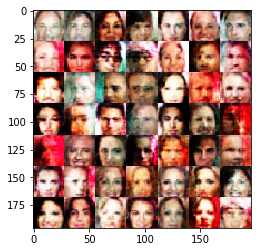

Epoch 1/1 Discriminator Loss: 1.4442 Generator Loss: 0.6273
Epoch 1/1 Discriminator Loss: 1.4279 Generator Loss: 0.7528
Epoch 1/1 Discriminator Loss: 1.4827 Generator Loss: 0.5812
Epoch 1/1 Discriminator Loss: 1.4349 Generator Loss: 0.8979
Epoch 1/1 Discriminator Loss: 1.4011 Generator Loss: 0.6270
Epoch 1/1 Discriminator Loss: 1.4408 Generator Loss: 0.6162
Epoch 1/1 Discriminator Loss: 1.3332 Generator Loss: 0.6796
Epoch 1/1 Discriminator Loss: 1.3167 Generator Loss: 0.7256
Epoch 1/1 Discriminator Loss: 1.4780 Generator Loss: 0.6380
Epoch 1/1 Discriminator Loss: 1.4332 Generator Loss: 0.6844


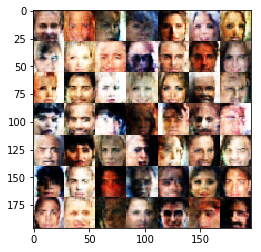

Epoch 1/1 Discriminator Loss: 1.3274 Generator Loss: 0.9069
Epoch 1/1 Discriminator Loss: 1.4498 Generator Loss: 0.7025
Epoch 1/1 Discriminator Loss: 1.4470 Generator Loss: 0.6389
Epoch 1/1 Discriminator Loss: 1.4801 Generator Loss: 0.7372
Epoch 1/1 Discriminator Loss: 1.5636 Generator Loss: 0.6690
Epoch 1/1 Discriminator Loss: 1.5153 Generator Loss: 0.6654
Epoch 1/1 Discriminator Loss: 1.4326 Generator Loss: 0.4993
Epoch 1/1 Discriminator Loss: 1.4304 Generator Loss: 0.6652
Epoch 1/1 Discriminator Loss: 1.3841 Generator Loss: 0.6988
Epoch 1/1 Discriminator Loss: 1.4531 Generator Loss: 0.7347


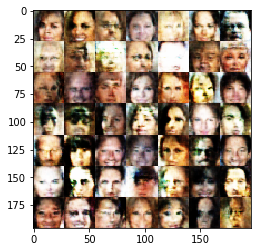

Epoch 1/1 Discriminator Loss: 1.4801 Generator Loss: 0.6486
Epoch 1/1 Discriminator Loss: 1.6328 Generator Loss: 0.5521
Epoch 1/1 Discriminator Loss: 1.3899 Generator Loss: 0.9591
Epoch 1/1 Discriminator Loss: 1.5543 Generator Loss: 0.5447
Epoch 1/1 Discriminator Loss: 1.3906 Generator Loss: 0.6998
Epoch 1/1 Discriminator Loss: 1.4888 Generator Loss: 0.6040
Epoch 1/1 Discriminator Loss: 1.2267 Generator Loss: 0.8301
Epoch 1/1 Discriminator Loss: 1.4764 Generator Loss: 0.6665
Epoch 1/1 Discriminator Loss: 1.3323 Generator Loss: 0.8435
Epoch 1/1 Discriminator Loss: 1.4742 Generator Loss: 0.6249


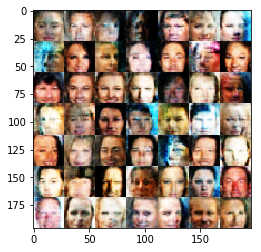

Epoch 1/1 Discriminator Loss: 1.4016 Generator Loss: 0.5635
Epoch 1/1 Discriminator Loss: 1.4530 Generator Loss: 0.7488
Epoch 1/1 Discriminator Loss: 1.4765 Generator Loss: 0.7882
Epoch 1/1 Discriminator Loss: 1.4472 Generator Loss: 0.5557
Epoch 1/1 Discriminator Loss: 1.5229 Generator Loss: 0.6078
Epoch 1/1 Discriminator Loss: 1.4553 Generator Loss: 0.6873
Epoch 1/1 Discriminator Loss: 1.4672 Generator Loss: 0.6665
Epoch 1/1 Discriminator Loss: 1.3660 Generator Loss: 0.7044
Epoch 1/1 Discriminator Loss: 1.4183 Generator Loss: 0.6217
Epoch 1/1 Discriminator Loss: 1.4162 Generator Loss: 0.7634


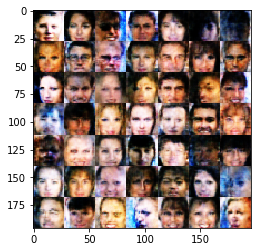

Epoch 1/1 Discriminator Loss: 1.5205 Generator Loss: 0.7168
Epoch 1/1 Discriminator Loss: 1.3508 Generator Loss: 0.7392
Epoch 1/1 Discriminator Loss: 1.4861 Generator Loss: 0.5942
Epoch 1/1 Discriminator Loss: 1.6336 Generator Loss: 0.5191
Epoch 1/1 Discriminator Loss: 1.4928 Generator Loss: 0.7246
Epoch 1/1 Discriminator Loss: 1.4211 Generator Loss: 0.7337
Epoch 1/1 Discriminator Loss: 1.3502 Generator Loss: 0.8113
Epoch 1/1 Discriminator Loss: 1.3513 Generator Loss: 0.5740
Epoch 1/1 Discriminator Loss: 1.3723 Generator Loss: 0.6263
Epoch 1/1 Discriminator Loss: 1.5441 Generator Loss: 0.6032


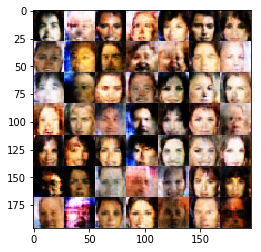

Epoch 1/1 Discriminator Loss: 1.1986 Generator Loss: 0.8005
Epoch 1/1 Discriminator Loss: 1.2911 Generator Loss: 0.8265
Epoch 1/1 Discriminator Loss: 1.5178 Generator Loss: 0.6304
Epoch 1/1 Discriminator Loss: 1.4008 Generator Loss: 0.6786
Epoch 1/1 Discriminator Loss: 1.4335 Generator Loss: 0.5970
Epoch 1/1 Discriminator Loss: 1.4273 Generator Loss: 0.6428


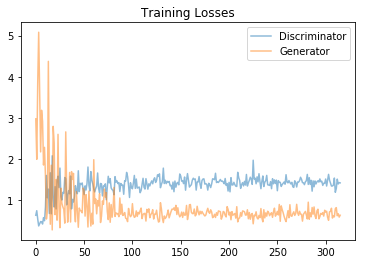

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.